<a href="https://colab.research.google.com/github/Parth0318/.net/blob/master/Liver_Cirrhosis_Stage_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.0 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from scipy.cluster.hierarchy import linkage, dendrogram
from pandas.plotting import andrews_curves
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.ensemble import StackingClassifier

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix,classification_report
from sklearn.utils.class_weight import compute_class_weight

import warnings
warnings.filterwarnings("ignore")


In [5]:
!pip install colorama


In [6]:
import pandas as pd
from io import StringIO
from IPython.display import display, HTML
from colorama import Fore, Style


# Define the function
def styled_heading(text, background_color='#282828', text_color='#FFD700'):
    return f"""
    <div style="
        text-align: center;
        background: {background_color};
        font-family: 'Montserrat', sans-serif;
        color: {text_color};
        padding: 15px;
        font-size: 24px;
        font-weight: bold;
        line-height: 1.5;
        border-radius: 15px;
        margin: 20px 10px;
        box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.3);
        border: 2px solid {text_color};
        max-width: 100%;
        word-wrap: break-word;
    ">
        {text}
    </div>
    <style>
    @media (max-width: 600px) {{
        div {{
            font-size: 20px;
            padding: 10px;
        }}
    }}
    </style>
    """

def print_error(message):
    display(HTML(styled_heading("Error", background_color='#B22222', text_color='white')))
    print(f"An error occurred: {message}")

def data_peek(df):
    try:
        # Display head and tail of the dataset
        for heading, df_part, bg_color, text_color in zip(
            ["The Head Of Dataset is:", "The Tail Of Dataset is:", "Numerical Summary of Data:"],
            [df.head(5), df.tail(5), df.describe()],
            ['#4B0082', '#006400', '#8B4513'],
            ['#FFFFFF', '#FFD700', '#FFFFFF']
        ):
            display(HTML(styled_heading(heading, background_color=bg_color, text_color=text_color)))
            display(HTML(df_part.to_html(index=False)))
            print()

        # Print shape data
        display(HTML(styled_heading("Shape Data:", background_color='#4682B4', text_color='#FFFFFF')))
        print(f'{Fore.CYAN}Shape of the Data: {Style.BRIGHT + str(df.shape) + Style.RESET_ALL}')
        print(f'{Fore.CYAN}Rows: {df.shape[0]}{Style.RESET_ALL}')
        print(f'{Fore.CYAN}Columns: {df.shape[1]}{Style.RESET_ALL}')
        print()

        # Print info of the data
        display(HTML(styled_heading("Info Of Data:", background_color='#2E8B57', text_color='#FFFFFF')))
        buffer = StringIO()
        df.info(buf=buffer)
        buffer.seek(0)
        info_str = buffer.read()
        display(HTML(f"<pre style='margin-bottom: 20px; font-family: Courier, monospace; font-size: 14px;'>{info_str}</pre>"))
        print()

        # Print categorical columns
        cat_cols = [col for col in df.columns if df[col].dtype == 'O']
        display(HTML(styled_heading("Categorical Columns of Data:", background_color='#D2691E', text_color='#FFFFFF')))
        print(f'{Fore.LIGHTMAGENTA_EX}The Categorical Columns of Data are:{Style.RESET_ALL} {cat_cols}')
        print()

        # Print numerical columns
        num_cols = [col for col in df.columns if df[col].dtype in ['float64', 'int64']]
        display(HTML(styled_heading("Numerical Columns of Data:", background_color='#8A2BE2', text_color='#FFFFFF')))
        print(f'{Fore.LIGHTMAGENTA_EX}The Numerical Columns of Data are:{Style.RESET_ALL} {num_cols}')
        print()

        # Print null values
        display(HTML(styled_heading("Null Values in Data:", background_color='#FF4500', text_color='#FFFFFF')))
        null_values = df.isnull().sum()
        display(HTML(f"<pre style='margin-bottom: 20px; font-family: Courier, monospace; font-size: 14px;'>{null_values}</pre>"))
        print()

        # Print duplicates check
        display(HTML(styled_heading("Duplicates Check in Data:", background_color='#4169E1', text_color='#FFFFFF')))
        duplicates_count = df.duplicated().sum()
        if duplicates_count > 0:
            print(f'{Fore.RED}Duplicates exist in the dataset. Total duplicates: {duplicates_count}{Style.RESET_ALL}')
        else:
            print(f'{Fore.GREEN}No duplicates found in the dataset.{Style.RESET_ALL}')
        print()

    except Exception as e:
        print_error(str(e))

df = pd.read_csv('/content/liver_cirrhosis.csv')


data_peek(df)


Shape of the Data: (25000, 19)
Rows: 25000
Columns: 19



The Categorical Columns of Data are: ['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']



The Numerical Columns of Data are: ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage']



Duplicates exist in the dataset. Total duplicates: 15361



In [ ]:
# Check the number of duplicate rows
num_duplicates = df.duplicated().sum()
print(f'Number of duplicate rows: {num_duplicates}')

# Drop the duplicate rows
df_cleaned = df.drop_duplicates()

# Verify duplicates are dropped
num_duplicates_after = df_cleaned.duplicated().sum()
print(f'Number of duplicate rows after dropping: {num_duplicates_after}')


Number of duplicate rows: 15361
Number of duplicate rows after dropping: 0


In [ ]:
# Binning/Discretization of Age
bins = [0, 25, 35, 45, 100]  # Define age bins
labels = ['Young', 'Adult', 'Middle-aged', 'Senior']  # Define labels for bins
df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels)

In [ ]:
!pip install joypy

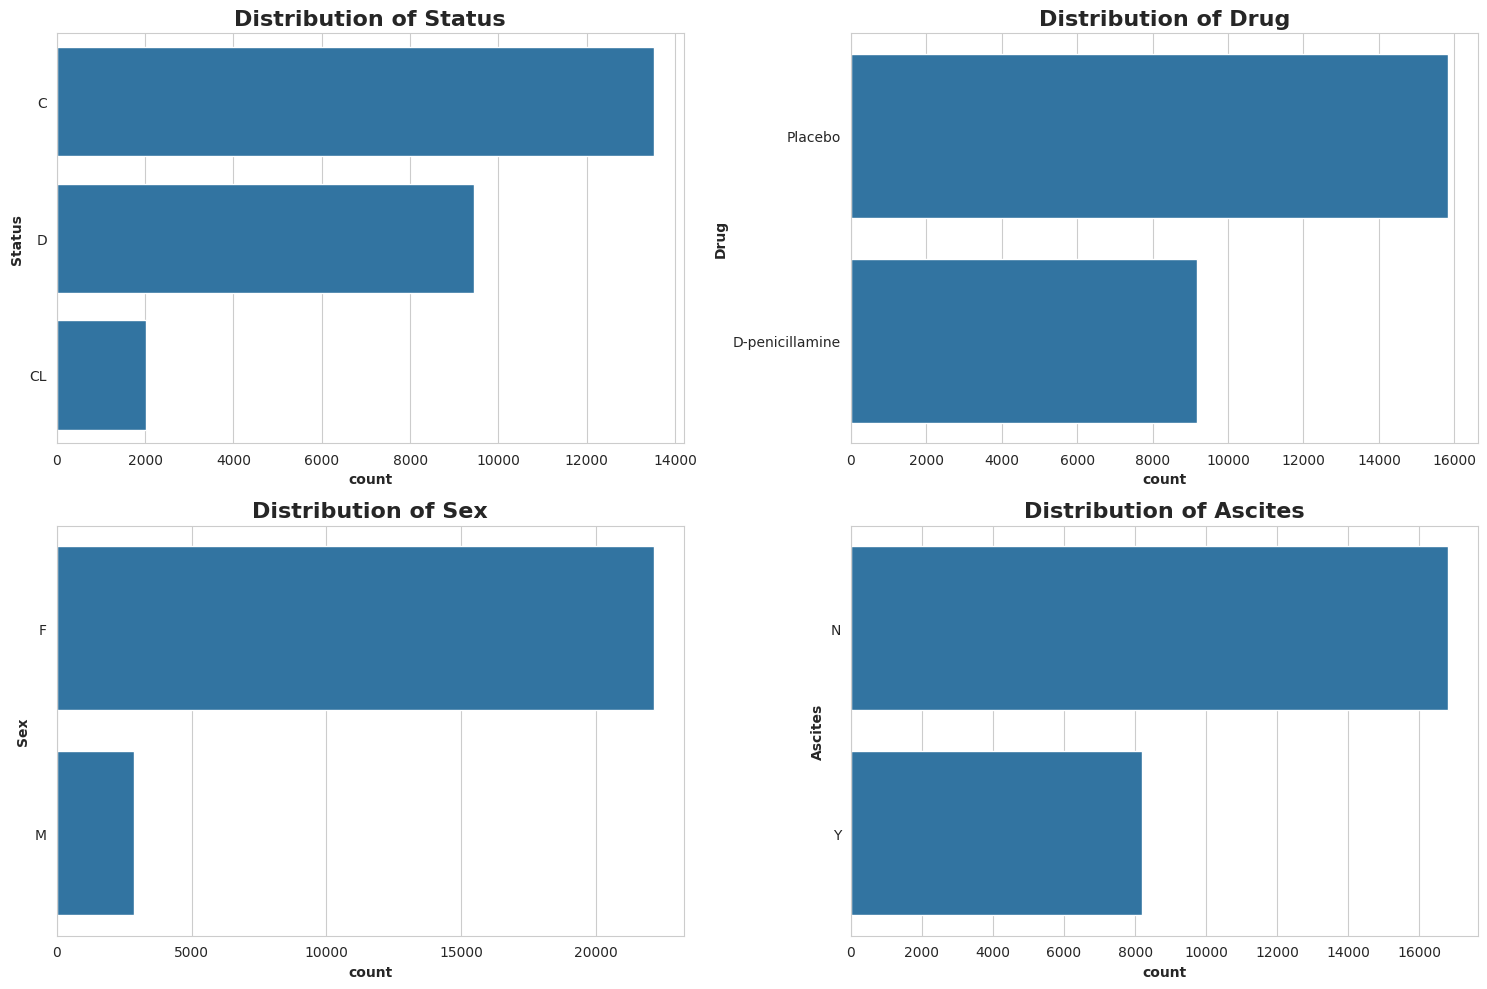

In [7]:
# Set the style for seaborn
sns.set_style("whitegrid")

# Create a figure and subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot for 'Status'
sns.countplot(y='Status', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Status', fontweight='bold', fontsize=16)
axes[0, 0].set_xlabel(axes[0, 0].get_xlabel(), fontweight='bold')
axes[0, 0].set_ylabel(axes[0, 0].get_ylabel(), fontweight='bold')

# Plot for 'Drug'
sns.countplot(y='Drug', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Drug', fontweight='bold', fontsize=16)
axes[0, 1].set_xlabel(axes[0, 1].get_xlabel(), fontweight='bold')
axes[0, 1].set_ylabel(axes[0, 1].get_ylabel(), fontweight='bold')

# Plot for 'Sex'
sns.countplot(y='Sex', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Sex', fontweight='bold', fontsize=16)
axes[1, 0].set_xlabel(axes[1, 0].get_xlabel(), fontweight='bold')
axes[1, 0].set_ylabel(axes[1, 0].get_ylabel(), fontweight='bold')

# Plot for 'Ascites'
sns.countplot(y='Ascites', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Ascites', fontweight='bold', fontsize=16)
axes[1, 1].set_xlabel(axes[1, 1].get_xlabel(), fontweight='bold')
axes[1, 1].set_ylabel(axes[1, 1].get_ylabel(), fontweight='bold')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


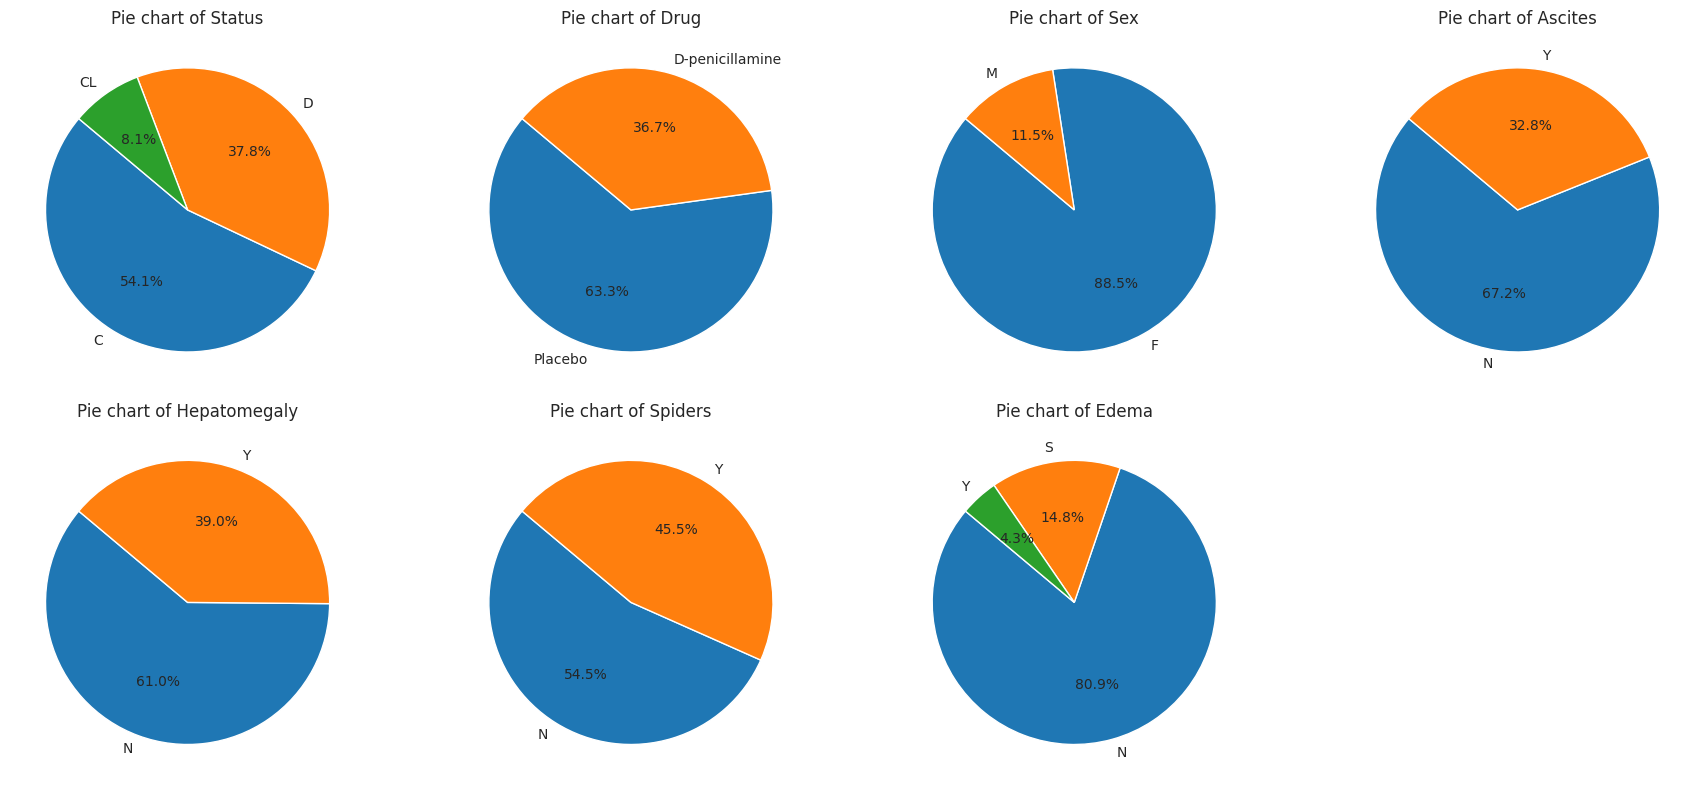

In [8]:
# Define the categorical columns
categorical_columns = ['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']

# Create subplots
fig, axs = plt.subplots(2, 4, figsize=(18, 8))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Plot each categorical variable
for i, column in enumerate(categorical_columns):
    # Pie chart
    if len(df[column].unique()) <= 5:
        axs[i].pie(df[column].value_counts(), labels=df[column].value_counts().index, autopct='%1.1f%%', startangle=140)
        axs[i].set_title(f'Pie chart of {column}')
    # Donut chart
    elif len(df[column].unique()) > 5 and len(df[column].unique()) <= 10:
        axs[i].pie(df[column].value_counts(), labels=df[column].value_counts().index, autopct='%1.1f%%', startangle=140)
        axs[i].add_artist(plt.Circle((0,0),0.70,fc='white'))
        axs[i].set_title(f'Donut chart of {column}')
    # Violin swarm plot
    elif len(df[column].unique()) > 10:
        sns.violinplot(x=column, data=df, ax=axs[i])
        sns.swarmplot(x=column, data=df, color='k', alpha=0.5, ax=axs[i])
        axs[i].set_title(f'Violin Swarm Plot of {column}')
    # Strip plot
    else:
        sns.stripplot(x=column, data=df, ax=axs[i])
        axs[i].set_title(f'Strip Plot of {column}')

# Hide any extra subplots if there are fewer than 8 categorical columns
for j in range(len(categorical_columns), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


In [10]:
!pip install joypy


<Figure size 1200x800 with 0 Axes>

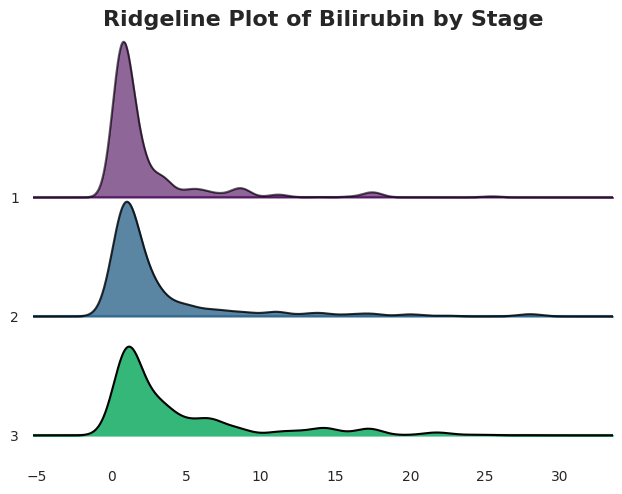

In [11]:
import joypy

plt.figure(figsize=(12, 8))
joypy.joyplot(data=df, by='Stage', column='Bilirubin', colormap=plt.cm.viridis, fade=True)
plt.title('Ridgeline Plot of Bilirubin by Stage', fontsize=16, fontweight='bold')
plt.show()


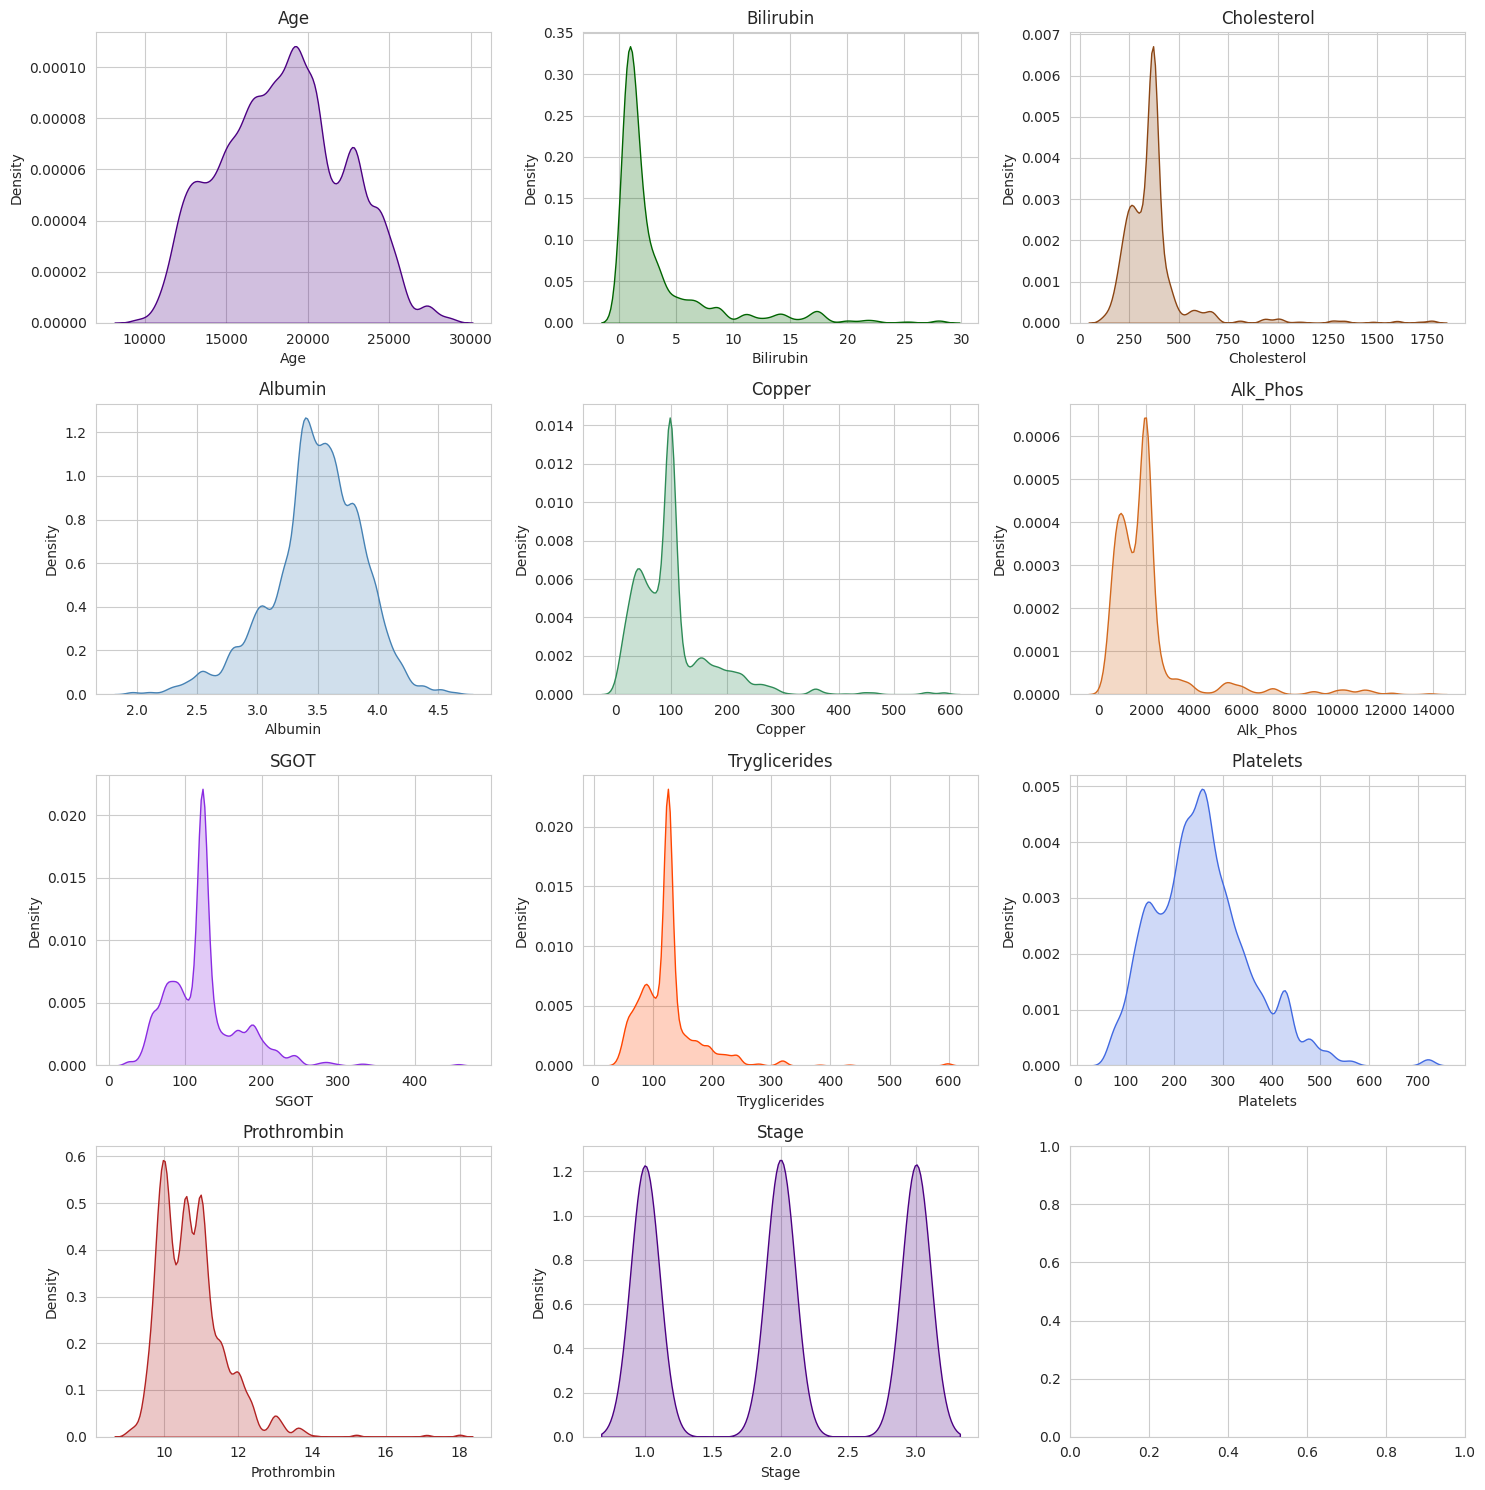

In [12]:
# Define color palette
colors = ['#4B0082', '#006400', '#8B4513', '#4682B4', '#2E8B57', '#D2691E', '#8A2BE2', '#FF4500', '#4169E1', '#B22222']

columns = ['Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage']
num_rows = 4
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
axes = axes.flatten()

for i, column in enumerate(columns):
    ax = axes[i]
    color = colors[i % len(colors)]  # Reuse colors if there are more columns than colors
    sns.kdeplot(data=df[column], ax=ax, fill=True, color=color)
    ax.set_title(column)
    ax.set_ylabel('Density')

plt.tight_layout()
plt.show()


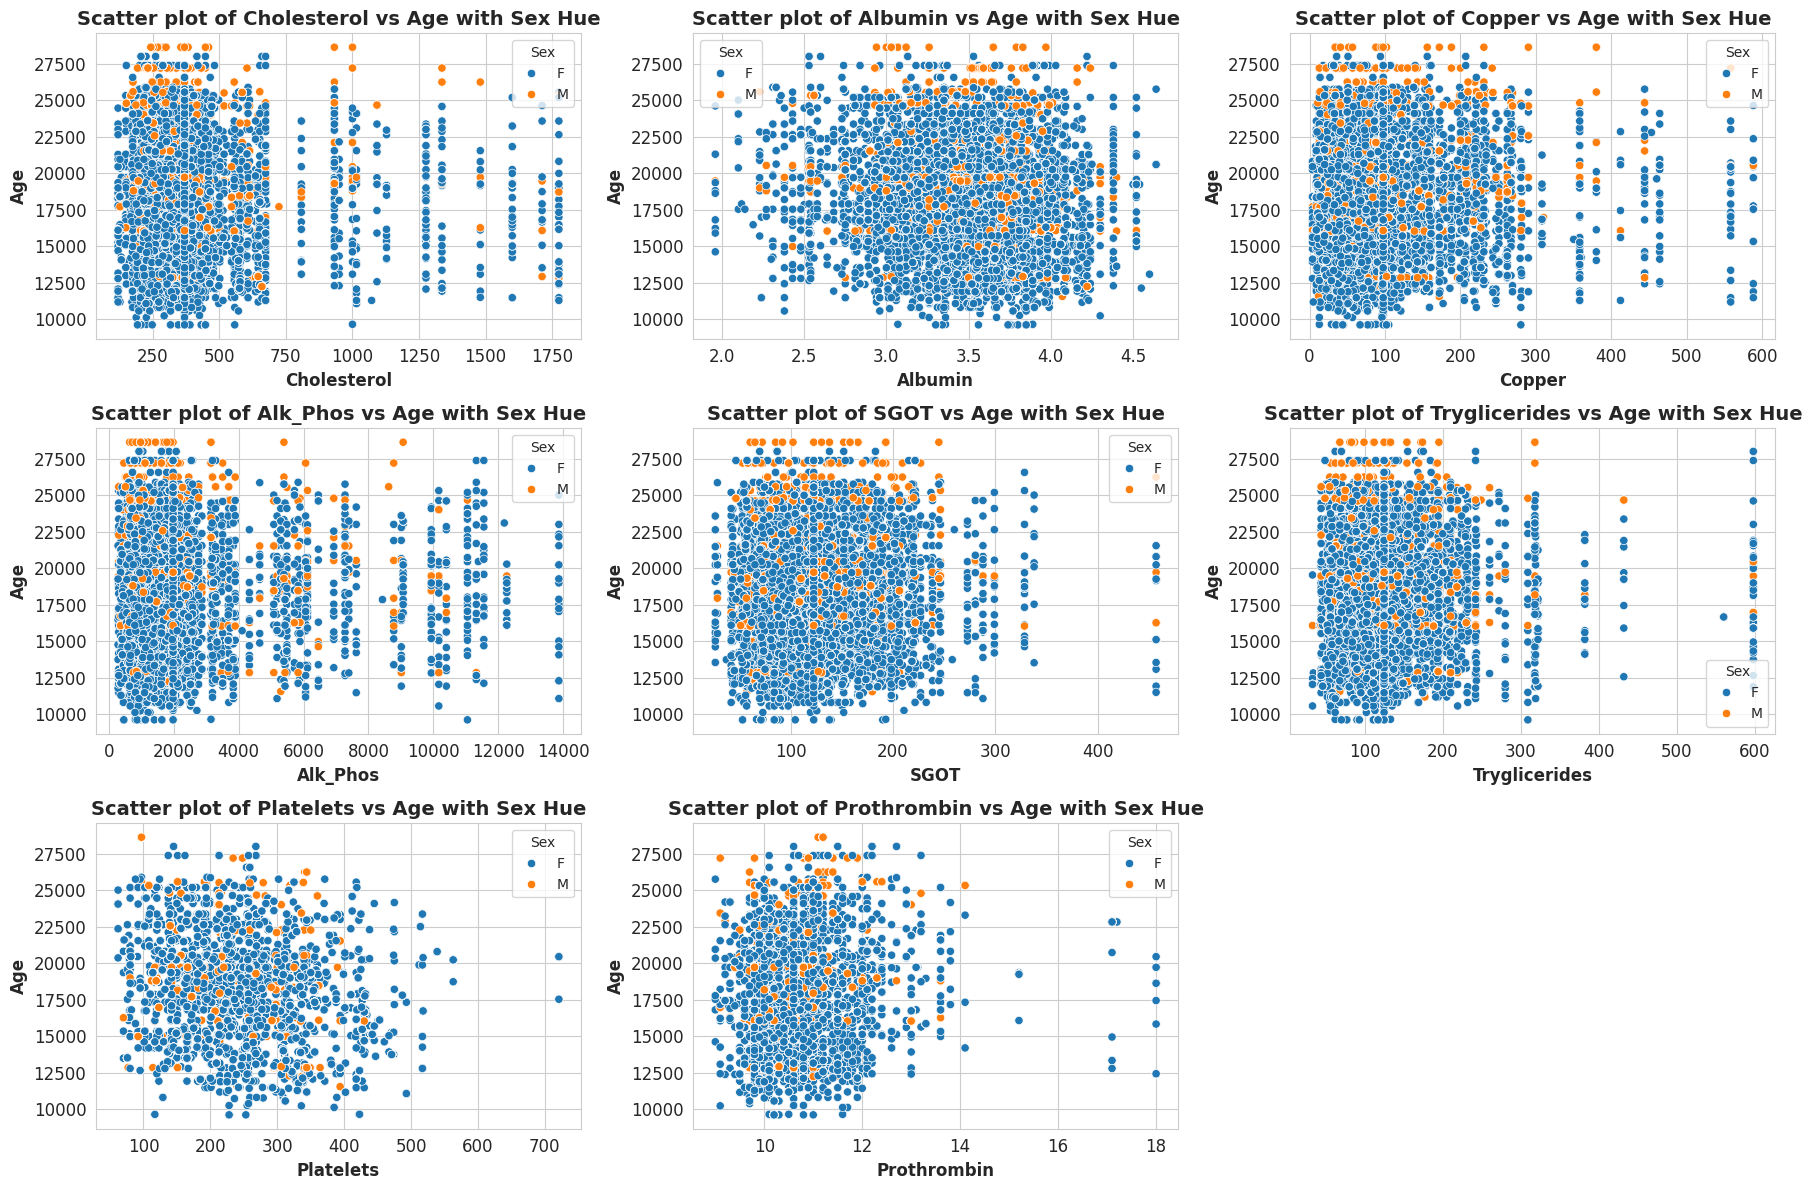

In [13]:
# Select the columns for bivariate analysis
bivariate_columns = ['Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']

# Create a figure and subplots
fig, axs = plt.subplots(3, 3, figsize=(18, 12))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Plot scatter plots for each pair of variables with 'Sex' as hue
for i, column in enumerate(bivariate_columns):
    sns.scatterplot(x=column, y='Age', hue='Sex', data=df, ax=axs[i])
    axs[i].set_title(f'Scatter plot of {column} vs Age with Sex Hue', fontsize=14, fontweight='bold')  # Increase font size and set title to bold
    axs[i].tick_params(axis='x', labelsize=12)
    axs[i].tick_params(axis='y', labelsize=12)
    axs[i].set_xlabel(column, fontsize=12, fontweight='bold')  # Increase font size and set xlabel to bold
    axs[i].set_ylabel('Age', fontsize=12, fontweight='bold')  # Increase font size and set ylabel to bold

# Hide any extra subplots if there are fewer than 12 variables
for j in range(len(bivariate_columns), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()



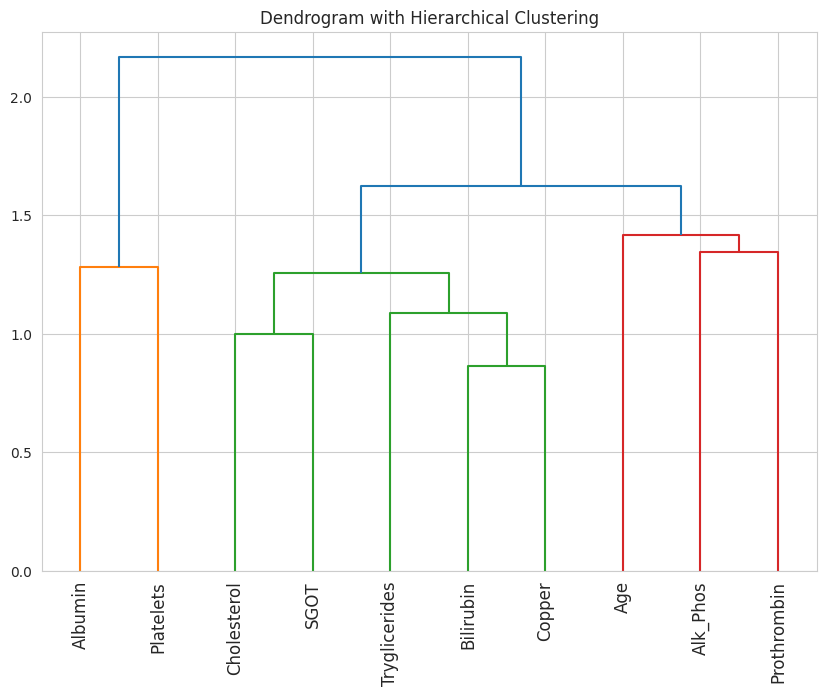

In [14]:
# Compute the correlation matrix
corr = df[['Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']].corr()

# Generate the linkage matrix
link = linkage(corr, method='complete')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(link, labels=corr.columns, leaf_rotation=90)
plt.title('Dendrogram with Hierarchical Clustering')
plt.show()


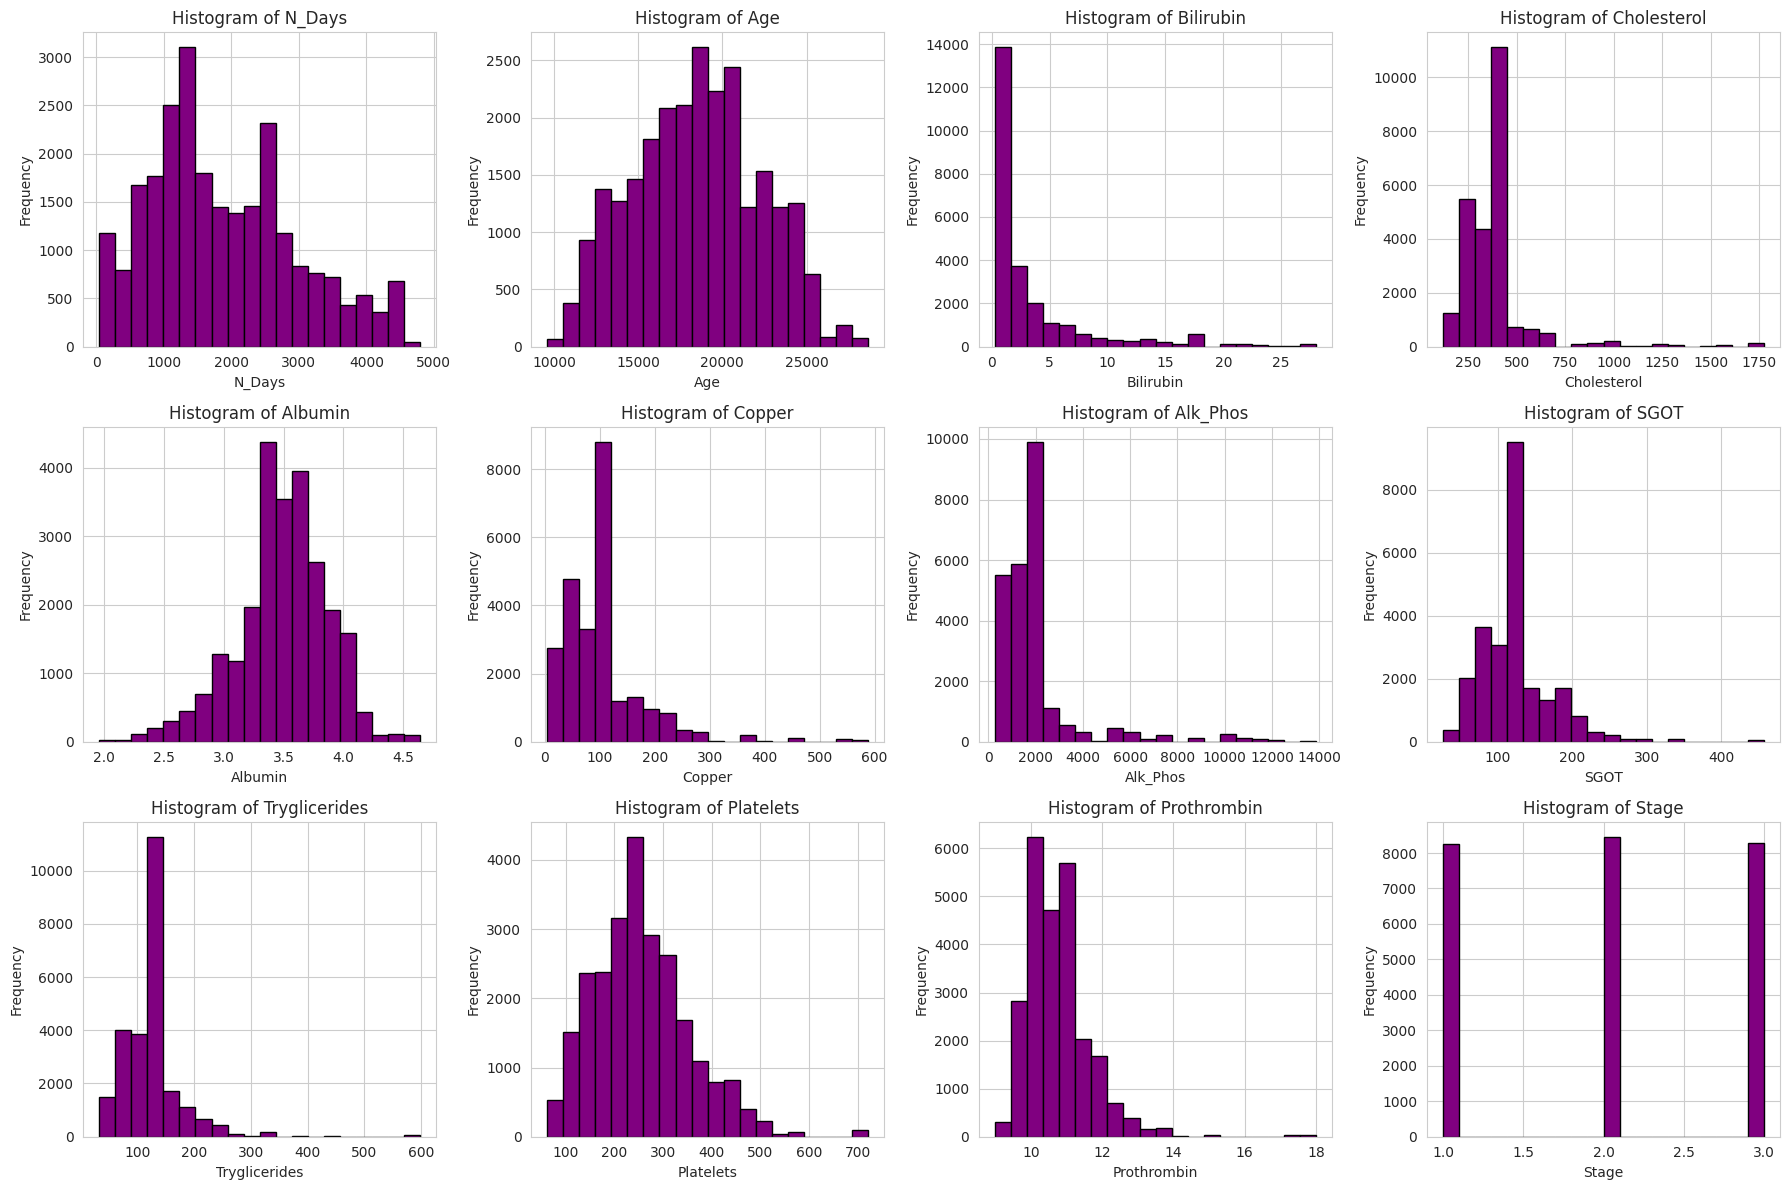

In [15]:
# Define the numeric columns
numeric_columns = ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
                   'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage']

# Create subplots
fig, axs = plt.subplots(3, 4, figsize=(18, 12))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Plot histogram for each numeric variable
for i, column in enumerate(numeric_columns):
    axs[i].hist(df[column], bins=20, color='purple', edgecolor='black')
    axs[i].set_title(f'Histogram of {column}')
    axs[i].set_xlabel(column)
    axs[i].set_ylabel('Frequency')

# Hide any extra subplots if there are fewer than 12 numeric columns
for j in range(len(numeric_columns), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


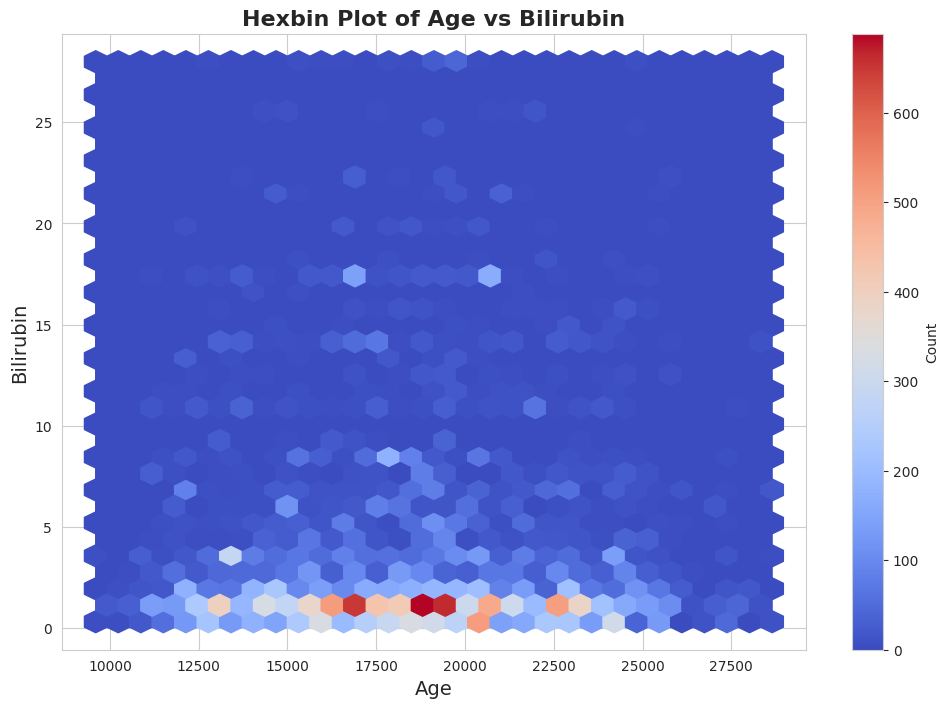

In [16]:
plt.figure(figsize=(12, 8))
plt.hexbin(df['Age'], df['Bilirubin'], gridsize=30, cmap='coolwarm')
plt.colorbar(label='Count')
plt.xlabel('Age', fontsize=14)
plt.ylabel('Bilirubin', fontsize=14)
plt.title('Hexbin Plot of Age vs Bilirubin', fontsize=16, fontweight='bold')
plt.show()


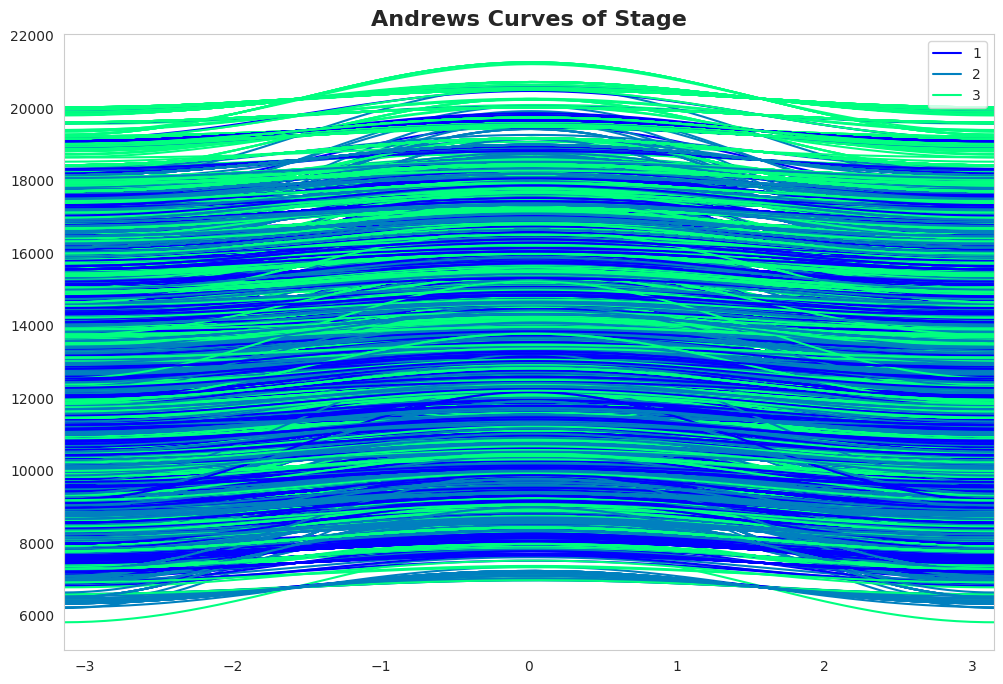

In [17]:
plt.figure(figsize=(12, 8))
andrews_curves(df[['Stage', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin']], 'Stage', colormap='winter')
plt.title('Andrews Curves of Stage', fontsize=16, fontweight='bold')
plt.show()


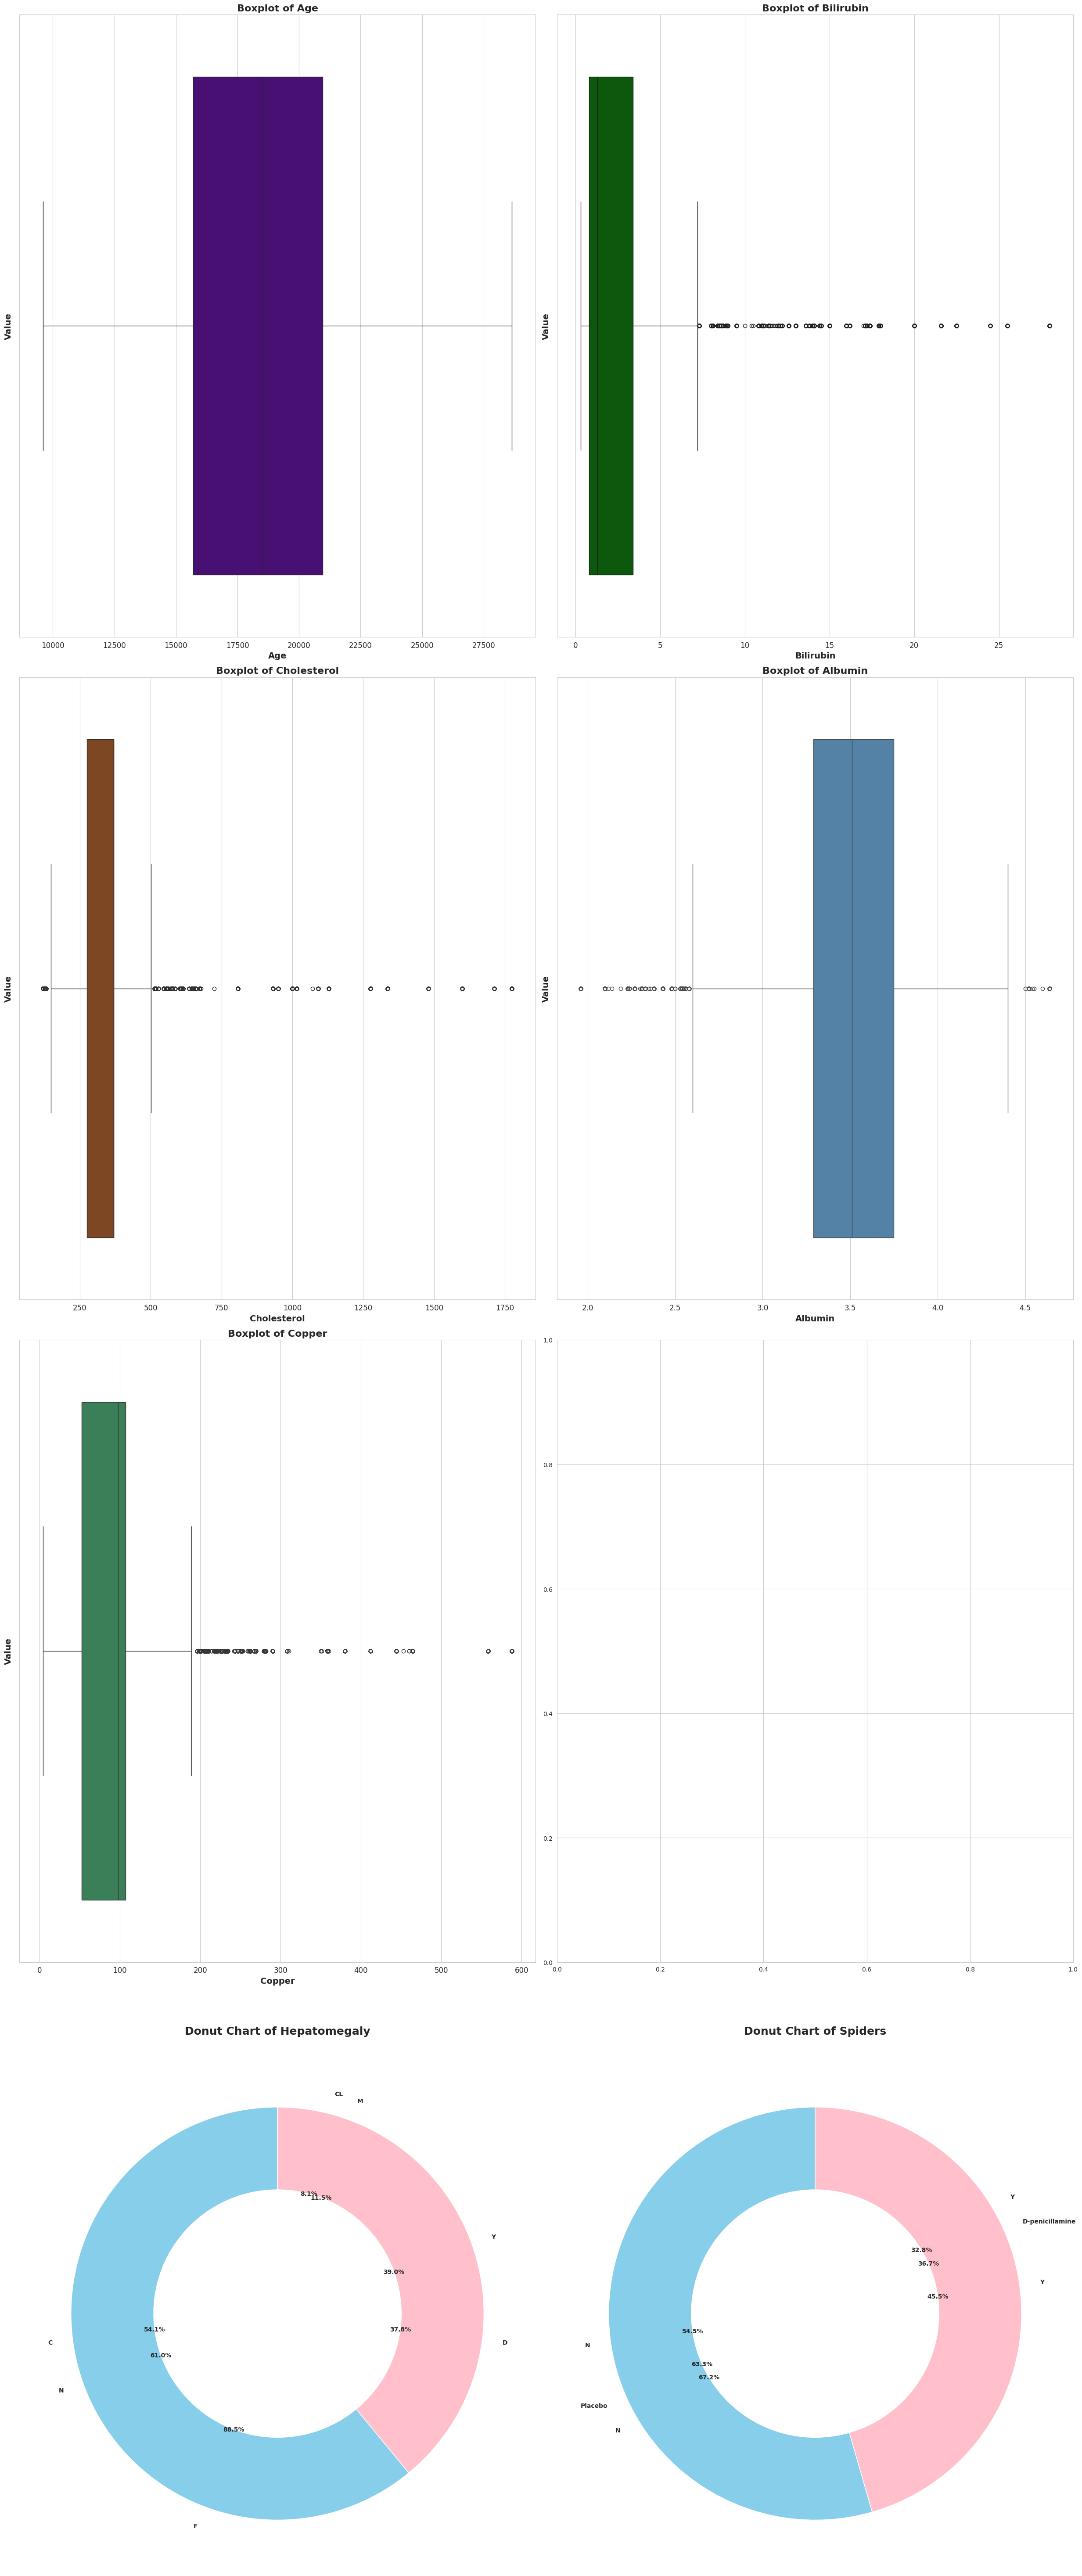

In [18]:
# Define colors
colors = ['#4B0082', '#006400', '#8B4513', '#4682B4', '#2E8B57', '#87CEEB', '#FFC0CB']

# Selecting columns
numerical_columns = ['Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper']
categorical_columns = ['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders']

# Set the style for seaborn
sns.set_style("whitegrid")

# Calculate the number of subplot rows needed for numerical columns
num_numerical_cols = len(numerical_columns)
num_subplot_rows = (num_numerical_cols + 1) // 2  # Ensure at least one row

# Create a figure and subplots
fig, axes = plt.subplots(num_subplot_rows + 1, 2, figsize=(25, 15 * (num_subplot_rows + 1)))

# Plot boxplots for numerical columns
for i, col in enumerate(numerical_columns):
    row_index = i // 2
    col_index = i % 2
    sns.boxplot(x=df[col], ax=axes[row_index, col_index], color=colors[i%len(colors)])  # Reuse colors if more numerical columns
    axes[row_index, col_index].set_title(f'Boxplot of {col}', fontsize=16, fontweight='bold')  # Increase font size and set title to bold
    axes[row_index, col_index].set_xlabel(col, fontsize=14, fontweight='bold')  # Increase font size and set xlabel to bold
    axes[row_index, col_index].set_ylabel('Value', fontsize=14, fontweight='bold')  # Increase font size and set ylabel to bold
    axes[row_index, col_index].tick_params(axis='both', labelsize=12)  # Increase tick label size

# Plot donut charts for categorical columns
for i, col in enumerate(categorical_columns):
    row_index = num_subplot_rows
    col_index = i % 2
    category_counts = df[col].value_counts()
    category_labels = category_counts.index
    category_sizes = category_counts.values
    pie_colors = ['#87CEEB', '#FFC0CB']  # Light blue and light pink colors
    axes[row_index, col_index].pie(category_sizes, labels=category_labels, autopct='%1.1f%%', startangle=90, colors=pie_colors, wedgeprops=dict(width=0.4, edgecolor='w'))
    axes[row_index, col_index].set_title(f'Donut Chart of {col}', fontsize=18, fontweight='bold', pad=35)  # Increase font size, set title to bold, and add padding
    axes[row_index, col_index].tick_params(axis='both', labelsize=18)  # Increase tick label size
    for text in axes[row_index, col_index].texts:
        text.set_fontweight('bold')  # Set percentages to bold

# Adjust layout
plt.tight_layout()


plt.show()


In [19]:
# Selecting numerical columns
numerical_columns = ['Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper']

# Calculate z-scores for numerical columns
z_scores = df[numerical_columns].apply(zscore)

# Define threshold for outliers (e.g., z-score > 3)
threshold = 3

# Filter DataFrame to exclude outliers
df_no_outliers = df[(z_scores.abs() < threshold).all(axis=1)]

# Calculate the percentage of outliers before removal
outliers_percentage_before = (df.shape[0] - df_no_outliers.shape[0]) / df.shape[0] * 100

# Display the shape before removing outliers
print("DataFrame shape before removing outliers:", df.shape)

# Display the number of removed rows (outliers)
removed_rows = df.shape[0] - df_no_outliers.shape[0]
print("Number of removed rows (outliers):", removed_rows)

# Display the percentage of outliers before removal
print("Percentage of outliers before removal:", outliers_percentage_before, "%")

# Update the original DataFrame with outliers removed
df = df_no_outliers.copy()

# Display the updated DataFrame shape
print("DataFrame shape after removing outliers:", df.shape)

# Calculate the percentage of outliers after removal
outliers_percentage_after = 0  # Since all outliers have been removed, the percentage is now 0

# Display the percentage of outliers after removal
print("Percentage of outliers after removal:", outliers_percentage_after, "%")


DataFrame shape before removing outliers: (25000, 19)
Number of removed rows (outliers): 1723
Percentage of outliers before removal: 6.8919999999999995 %
DataFrame shape after removing outliers: (23277, 19)
Percentage of outliers after removal: 0 %


In [20]:
le = LabelEncoder()
for col in df.columns:
    if df[col].dtype == 'category' or df[col].dtype == 'object':
        df[col] = le.fit_transform(df[col])


In [21]:
# Define the features and the target
X = df.drop(columns=['Stage'], axis=1)
y = df['Stage']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [22]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [23]:
# Initialize and train the SVC classifier
svc = SVC()
svc.fit(X_train_scaled, y_train)

# Make predictions
y_pred_svc = svc.predict(X_test_scaled)
print("Accuracy Score:\n", accuracy_score(y_test, y_pred_svc))

# Evaluate the classifier
print("SVC Classifier Report:\n", classification_report(y_test, y_pred_svc))



Accuracy Score:
 0.8479381443298969
SVC Classifier Report:
               precision    recall  f1-score   support

           1       0.84      0.85      0.84      1584
           2       0.80      0.83      0.82      1538
           3       0.91      0.86      0.89      1534

    accuracy                           0.85      4656
   macro avg       0.85      0.85      0.85      4656
weighted avg       0.85      0.85      0.85      4656



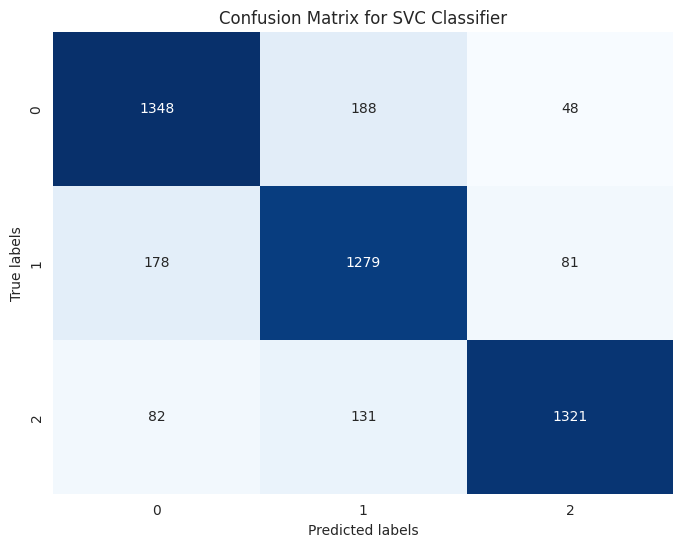

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm_svc = confusion_matrix(y_test, y_pred_svc)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svc, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for SVC Classifier')
plt.show()


In [25]:

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing steps for numerical features
numeric_features = ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Feature Selection
# SelectKBest with f_classif score function
selector = SelectKBest(score_func=f_classif)

# Combine preprocessing and feature selection steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

# Define models and pipelines
models = {
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier()
}

pipelines = {}
for name, model in models.items():
    pipelines[name] = Pipeline(steps=[('preprocessor', preprocessor),
                                      ('selector', selector),
                                      ('model', model)])

# Define hyperparameters for each model
param_grids = {
    'DecisionTree': {'selector__k': [2, 4, 6]},
    'RandomForest': {'selector__k': [2, 4, 6], 'model__n_estimators': [100, 200, 300]},
    'KNN': {'selector__k': [2, 4, 6], 'model__n_neighbors': [3, 5, 7]}
}

# Perform GridSearchCV for each model
results = {}
for name, pipeline in pipelines.items():
    grid_search = GridSearchCV(pipeline, param_grid=param_grids[name], cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    results[name] = grid_search

# Evaluate models
for name, result in results.items():
    print(f"Model: {name}")
    print("Best parameters:", result.best_params_)
    print("Train Accuracy:", result.best_score_)
    y_pred = result.predict(X_test)
    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, average='weighted'))
    print("Recall:", recall_score(y_test, y_pred, average='weighted'))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Model: DecisionTree
Best parameters: {'selector__k': 4}
Train Accuracy: 0.9254067431281943
Test Accuracy: 0.9349226804123711
Precision: 0.9348905360788008
Recall: 0.9349226804123711
Confusion Matrix:
 [[1477   71   36]
 [  68 1419   51]
 [  37   40 1457]]
Model: RandomForest
Best parameters: {'model__n_estimators': 300, 'selector__k': 6}
Train Accuracy: 0.9500029700329442
Test Accuracy: 0.9559707903780069
Precision: 0.955942021679442
Recall: 0.9559707903780069
Confusion Matrix:
 [[1509   53   22]
 [  53 1453   32]
 [  20   25 1489]]
Model: KNN
Best parameters: {'model__n_neighbors': 3, 'selector__k': 4}
Train Accuracy: 0.9005963566634707
Test Accuracy: 0.907860824742268
Precision: 0.9080625366933044
Recall: 0.907860824742268
Confusion Matrix:
 [[1460   87   37]
 [ 107 1365   66]
 [  59   73 1402]]


Model: DecisionTree


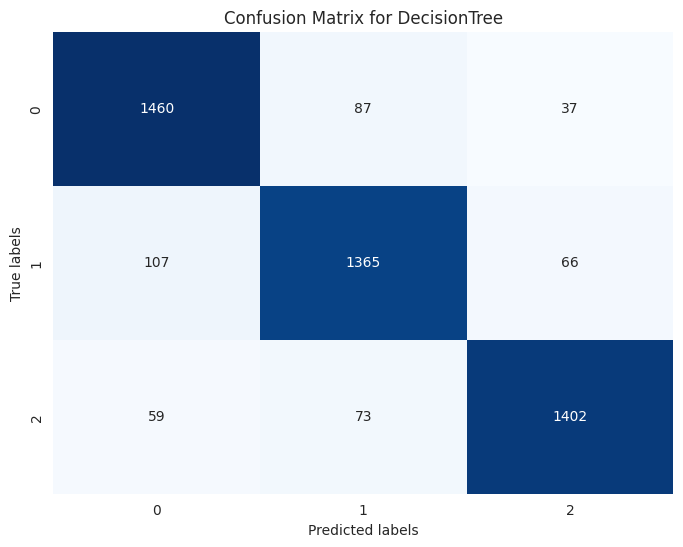

Model: RandomForest


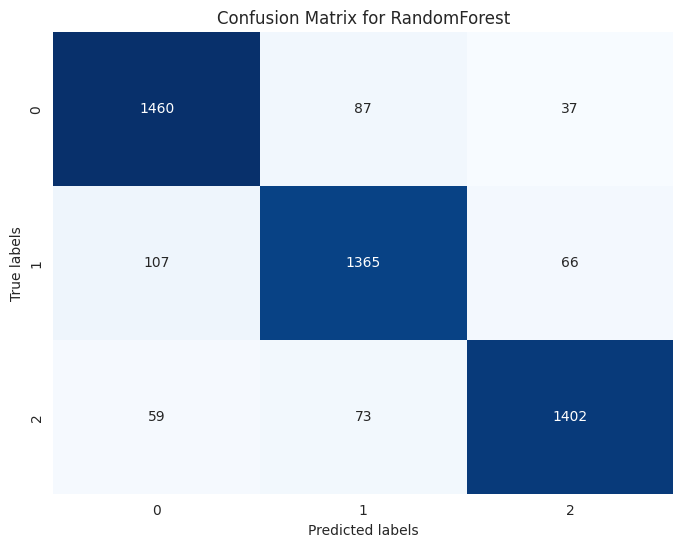

Model: KNN


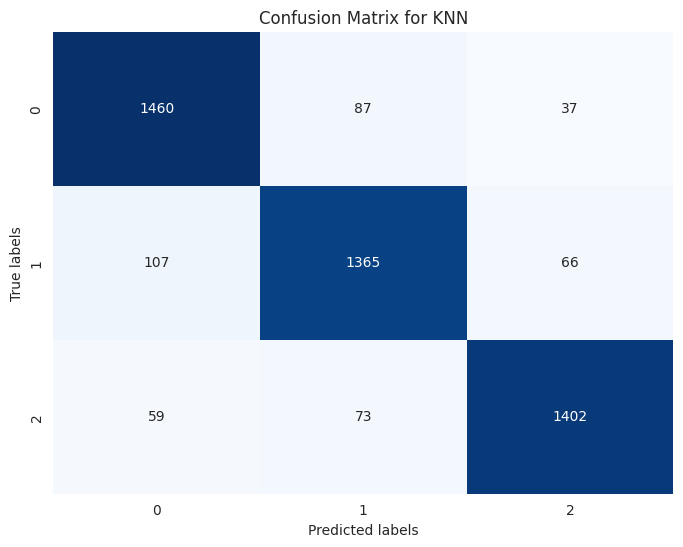

In [26]:
# Evaluate models
for name, result in results.items():
    print(f"Model: {name}")
    cm = confusion_matrix(y_test, y_pred)
    # Display confusion matrix as heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()


In [27]:
y = y.astype(str)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check class labels in y_train
unique_labels = np.unique(y_train)
print("Unique class labels in y_train:", unique_labels)

# Compute class weights for CatBoost
class_weights = compute_class_weight(class_weight='balanced', classes=unique_labels, y=y_train)
class_weights = dict(zip(unique_labels, class_weights))
print("Class weights:", class_weights)

# Define preprocessing steps for numerical features
numeric_features = ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])

# Feature Selection
# SelectKBest with f_classif score function
selector = SelectKBest(score_func=f_classif)

# Combine preprocessing and feature selection steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

# Define models
lgbm = LGBMClassifier(class_weight='balanced')
catboost = CatBoostClassifier(class_weights=class_weights, silent=True)

# Define the stacking ensemble
estimators = [
    ('LightGBM', lgbm),
    ('CatBoost', catboost)
]
stacking_model = StackingClassifier(estimators=estimators, final_estimator=LGBMClassifier())

# Define pipelines
pipelines = {
    'LightGBM': Pipeline(steps=[('preprocessor', preprocessor),
                                ('selector', selector),
                                ('model', lgbm)]),
    'CatBoost': Pipeline(steps=[('preprocessor', preprocessor),
                                ('selector', selector),
                                ('model', catboost)]),
    'Stacking': Pipeline(steps=[('preprocessor', preprocessor),
                                ('selector', selector),
                                ('model', stacking_model)])
}

# Define hyperparameters for each model
param_grids = {
    'LightGBM': {'selector__k': [2, 4, 6, 8, 10], 'model__num_leaves': [31, 50, 100, 150], 'model__max_depth': [-1, 5, 10, 15]},
    'CatBoost': {'selector__k': [2, 4, 6, 8, 10], 'model__iterations': [100, 200, 300, 500], 'model__depth': [4, 6, 8, 10]},
    'Stacking': {'selector__k': [2, 4, 6, 8, 10], 'model__final_estimator__n_estimators': [100, 200, 300]}
}

# Perform RandomizedSearchCV for each model
results = {}
for name, pipeline in pipelines.items():
    try:
        random_search = RandomizedSearchCV(pipeline, param_distributions=param_grids[name], n_iter=50, cv=5, scoring='accuracy', random_state=42)
        random_search.fit(X_train, y_train)
        results[name] = random_search
    except Exception as e:
        print(f"Error with model {name}: {e}")

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [28]:
y = y.astype(str)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check class labels in y_train
unique_labels = np.unique(y_train)
print("Unique class labels in y_train:", unique_labels)

# Compute class weights for CatBoost
class_weights = compute_class_weight(class_weight='balanced', classes=unique_labels, y=y_train)
class_weights = dict(zip(unique_labels, class_weights))
print("Class weights:", class_weights)

# Define preprocessing steps for numerical features
numeric_features = ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])

# Feature Selection
# SelectKBest with f_classif score function
selector = SelectKBest(score_func=f_classif)

# Combine preprocessing and feature selection steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

# Define models
lgbm = LGBMClassifier(class_weight='balanced')
catboost = CatBoostClassifier(class_weights=class_weights, silent=True)

# Define the stacking ensemble
estimators = [
    ('LightGBM', lgbm),
    ('CatBoost', catboost)
]
stacking_model = StackingClassifier(estimators=estimators, final_estimator=LGBMClassifier())

# Define pipelines
pipelines = {
    'LightGBM': Pipeline(steps=[('preprocessor', preprocessor),
                                ('selector', selector),
                                ('model', lgbm)]),
    'CatBoost': Pipeline(steps=[('preprocessor', preprocessor),
                                ('selector', selector),
                                ('model', catboost)]),
    'Stacking': Pipeline(steps=[('preprocessor', preprocessor),
                                ('selector', selector),
                                ('model', stacking_model)])
}

# Define hyperparameters for each model
param_grids = {
    'LightGBM': {'selector__k': [2, 4, 6], 'model__num_leaves': [31, 50, 100], 'model__max_depth': [-1, 5, 10]},
    'CatBoost': {'selector__k': [2, 4, 6], 'model__iterations': [100, 200, 300]},
    'Stacking': {'selector__k': [2, 4, 6], 'model__final_estimator__n_estimators': [100, 200]}
}

# Perform GridSearchCV for each model
results = {}
for name, pipeline in pipelines.items():
    try:
        grid_search = GridSearchCV(pipeline, param_grid=param_grids[name], cv=5, scoring='accuracy')
        grid_search.fit(X_train, y_train)
        results[name] = grid_search
    except Exception as e:
        print(f"Error with model {name}: {e}")

# Evaluate models
for name, result in results.items():
    print(f"Model: {name}")
    print("Best parameters:", result.best_params_)
    print("Train Accuracy:", result.best_score_)
    y_pred = result.predict(X_test)
    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, average='weighted'))
    print("Recall:", recall_score(y_test, y_pred, average='weighted'))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [29]:
if 'Stacking' in results:
    result_stacking = results['Stacking']
    y_pred_stacking = result_stacking.predict(X_test)

    print("\nEvaluation results for Stacking:")
    print("Test Accuracy:", accuracy_score(y_test, y_pred_stacking))
    print("Precision:", precision_score(y_test, y_pred_stacking, average='weighted'))
    print("Recall:", recall_score(y_test, y_pred_stacking, average='weighted'))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_stacking))
else:
    print("The Stacking model was not successfully trained.")


The Stacking model was not successfully trained.


In [30]:
print("Keys in results dictionary:", results.keys())


Keys in results dictionary: dict_keys(['LightGBM', 'CatBoost'])


In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# Evaluate the LightGBM model
result_lightgbm = results['LightGBM']
y_pred_lightgbm = result_lightgbm.predict(X_test)

print("\nEvaluation results for LightGBM:")
print("Test Accuracy:", accuracy_score(y_test, y_pred_lightgbm))
print("Precision:", precision_score(y_test, y_pred_lightgbm, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_lightgbm, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lightgbm))



Evaluation results for LightGBM:
Test Accuracy: 0.9649914089347079
Precision: 0.9649728841441382
Recall: 0.9649914089347079
Confusion Matrix:
 [[1521   45   18]
 [  43 1472   23]
 [  16   18 1500]]


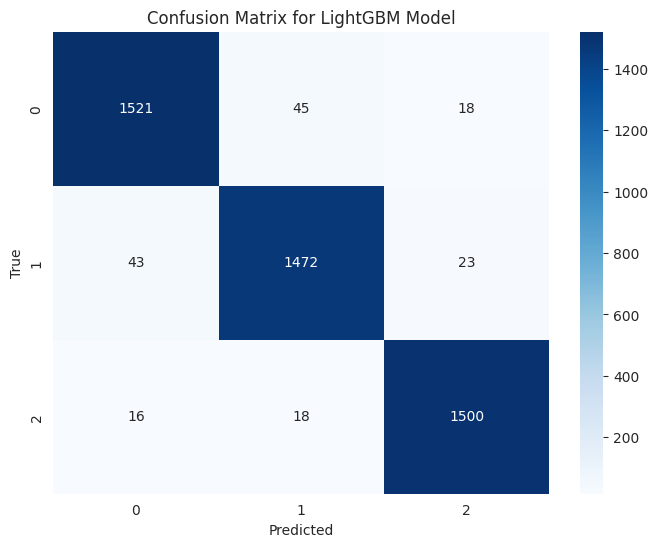

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
cm_lightgbm = confusion_matrix(y_test, y_pred_lightgbm)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lightgbm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for LightGBM Model')
plt.show()


In [33]:
# Evaluate the CatBoost model
result_catboost = results['CatBoost']
y_pred_catboost = result_catboost.predict(X_test)

print("\nEvaluation results for CatBoost:")
print("Test Accuracy:", accuracy_score(y_test, y_pred_catboost))
print("Precision:", precision_score(y_test, y_pred_catboost, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_catboost, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_catboost))



Evaluation results for CatBoost:
Test Accuracy: 0.9559707903780069
Precision: 0.9559961562811009
Recall: 0.9559707903780069
Confusion Matrix:
 [[1502   54   28]
 [  40 1468   30]
 [  25   28 1481]]


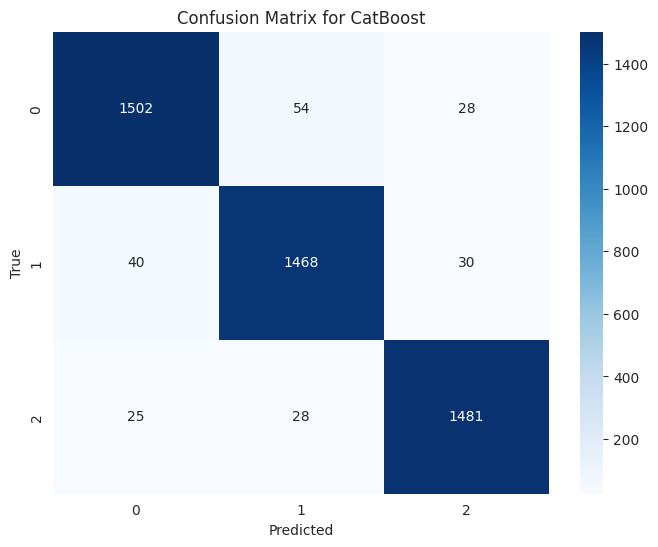

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
cm_catboost = confusion_matrix(y_test, y_pred_catboost)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_catboost, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for CatBoost')
plt.show()
